In [202]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
#try:
#    os.chdir("L:\laupodteam\AIOS\Huibert-Jan\Celldynclustering\celldyn_embedder")
#except FileNotFoundError:
#    os.chdir('C:/Users/Huibert-Jan/Documents/Werk/UMCU/celldyn_embedder')    

import sys
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#import pacmap
import umap
#import trimap

#from scipy.stats import chisquare, chi2_contingency, pearsonr
#from scipy.stats import kendalltau,spearmanr, weightedtau, theilslopes, wilcoxon, ttest_rel
#from scipy.spatial import distance
#import dcor

from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
#from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#from sklearn.decomposition import PCA
#from sklearn.manifold import Isomap, MDS, SpectralEmbedding
from sklearn.manifold import LocallyLinearEmbedding as LLE, TSNE, smacof, trustworthiness


#from sklearn.metrics import rand_score, adjusted_mutual_info_score, adjusted_rand_score
#from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
#from sklearn.neighbors import KNeighborsClassifier as KNN
#from sklearn.cluster import KMeans

from hembedder.utils.distance import poincarre_dist, hyperboloid_dist, fractional_distance, Distance
#from hembedder.utils.quality_metrics import CDEmbeddingPerformance
#import numpy.linalg as la
#import torch 

#from numba import njit

#import faiss
import gc

from sklego.meta import ZeroInflatedRegressor
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
plot_embedding = True

In [87]:
celldyn_full = pd.read_feather("L:\laupodteam\AIOS\Bram\data\CellDyn\\artifacts\celldyn_FULL_transformed_miceforest100_df.feather")
meas_columns = [c for c in celldyn_full.columns if ('c_b' in c) | ("COMBO" in c)]
mode_columns = [c for c in celldyn_full.columns if 'c_m' in c]
alrt_columns = [c for c in celldyn_full.columns if 'alrt' in c.lower()]
c_s_columns = [c for c in celldyn_full.columns if 'c_s_' in c.lower()]
celldyn_full.drop(['index'], axis=1, inplace=True)

## Age predictor

In [209]:
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.linear_model import Lasso, ElasticNet, HuberRegressor, LogisticRegression
from sklearn.model_selection import StratifiedGroupKFold

In [89]:
celldyn_full = celldyn_full.assign(gender=celldyn_full.gender.map({'M':0, 'F':1}))
celldyn_full.dropna(subset=['gender','draw_hour'], axis=0, inplace=True)

In [196]:
flat_dist = pdist(celldyn_full.sample(100000)[meas_columns].values.T, metric='correlation')
Z_ward = hierarchy.linkage(flat_dist, method='ward')
CClusters = hierarchy.fcluster(Z_ward, 0.1, criterion='distance')
cluster_dict = dict(zip(meas_columns, CClusters))

feature_selection = []
used_keys = []
for k,v in cluster_dict.items():
    if v not in used_keys:
        feature_selection.append(k)
        used_keys.append(v)
print(f"We are left with {len(feature_selection)} features")

independent_variables = feature_selection+['gender','draw_hour']

We are left with 72 features


In [199]:
sample_df = celldyn_full.sample(100000)
X = sample_df[independent_variables].values
y = sample_df['age'].values
# clip the ages
y = np.clip(y, 0, 90)

groups = sample_df['studyid_alle_celldyn'].values
indcs = np.arange(0, np.unique(groups).shape[0], 1)
group = np.unique(groups)
groups_dict = dict(zip(group, indcs))
reind_groups = np.array([groups_dict[g] for g in groups])

In [212]:
reg = HistGradientBoostingRegressor(max_iter=1000, 
                                    max_leaf_nodes=10,
                                    max_depth=8, 
                                    learning_rate=0.1, 
                                    l2_regularization=0.1,
                                    min_samples_leaf=50, 
                                    validation_fraction=0.1,
                                    early_stopping=True,
                                    verbose=0)
clf = HistGradientBoostingClassifier(max_iter=1000, 
                                    max_leaf_nodes=10,
                                    max_depth=8, 
                                    learning_rate=0.1, 
                                    l2_regularization=0.1,
                                    min_samples_leaf=50, 
                                    validation_fraction=0.1,
                                    early_stopping=True,
                                    verbose=0)

mclf = ZeroInflatedRegressor(classifier=clf, regressor=reg)

In [213]:
# make a StratifiedGroupKFold object
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
# create the training and test indices, the group is determined by the patient id, 
# the stratification is determined by the age
res_dict_list = []
feature_dict_list = []
for fold, (train_index, test_index) in tqdm(enumerate(cv.split(X, y, groups=reind_groups))):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #groups_train, groups_test = groups[train_index], groups[test_index]
    mclf.fit(X_train, y_train)    
    res_dict = {'y_test':y_test, 
                'y_pred':mclf.predict(X_test),
                'indcs': test_index, 
                'group': groups[test_index], 
                'fold': [fold]*len(test_index)}

    feat_dict = {'fold': fold}
    if mclf.__dir__().__contains__('feature_importances_'):
        feat_dict.update(dict(zip(['featImp_'+iv for iv in independent_variables], clf.feature_importances_)))
    
    if mclf.__dir__().__contains__('coef_'):
        feat_dict.update(dict(zip(['coef_'+iv for iv in independent_variables], clf.coef_)))
    res_dict_list.append(res_dict)
    feature_dict_list.append(feat_dict)

5it [01:24, 16.80s/it]


In [214]:
res_df = pd.concat([pd.DataFrame(res_dict) for res_dict in res_dict_list], axis=0)
feat_df = pd.DataFrame(feature_dict_list)

Text(0.5, 1.0, 'Zero-inflated regressor for age prediction with non-embedded data')

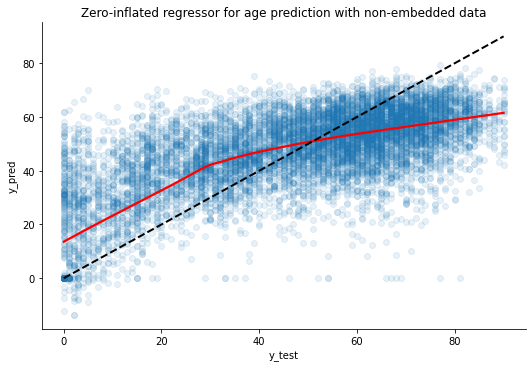

In [232]:
sns.lmplot(x='y_test', y='y_pred', data=res_df.sample(10000), height=5, aspect=1.5, 
            scatter_kws={'alpha':0.1}, line_kws={'color':'red'}, lowess=True)
#  add diagonal line
plt.plot([0, 90], [0, 90], color='black', linestyle='--', lw=2)
plt.title("Zero-inflated regressor for age prediction with non-embedded data")

## Embedder

In [4]:
# metric = 'manhattan'
# metric = poincarre_dist
# metric = hyperboloid_dist
# metric = 'seuclidean'
# metric = 'cosine'
# output_metric='hyperboloid'

In [5]:
metric = 'euclidean' # poincarre_dist
output_metric= 'euclidean' # 'hyperboloid' # 'hyperboloid'
densmap = False
init = 'spectral'
n_dims = 6
n_n = 50
n_epochs = 500

model_str = "_".join(['umap', metric, output_metric, init, 'dims', str(n_dims), 'n_n', str(n_n), 'n_epochs', str(n_epochs), 'densmap', str(densmap)])

embedder_full = umap.UMAP(n_components=n_dims, metric=metric, output_metric=output_metric, init=init,
                          n_neighbors=n_n, min_dist = 0.0, n_jobs=4, n_epochs=n_epochs, 
                          low_memory=True, 
                          verbose=True, densmap=densmap, dens_lambda=0.1, dens_frac=0.1, 
                          repulsion_strength=1.1, negative_sample_rate=10, random_state=42)

#distancer = Distance()
#le_pipe = Pipeline([('scaler', MinMaxScaler()),('distancer', distancer), ('embedder', embedder_full)])
le_pipe = Pipeline([('embedder', embedder_full)])

sample_index = celldyn_full.sample(frac=1.).index
le_pipe.fit(celldyn_full.loc[sample_index, meas_columns]) # final_columns  .to_numpy(dtype = np.float32)

UMAP(dens_frac=0.0, dens_lambda=0.0, low_memory=False, metric='manhattan',
     min_dist=0.0, n_components=6, n_epochs=500, n_jobs=4, n_neighbors=50,
     negative_sample_rate=10, output_metric='manhattan', random_state=42,
     repulsion_strength=1.1, verbose=True)
Construct fuzzy simplicial set
Wed Dec 14 17:26:09 2022 Finding Nearest Neighbors
Wed Dec 14 17:26:10 2022 Building RP forest with 64 trees
Wed Dec 14 17:28:45 2022 NN descent for 22 iterations
	 1  /  22
	 2  /  22
	 3  /  22
	 4  /  22
	 5  /  22
	Stopping threshold met -- exiting after 5 iterations
Wed Dec 14 17:48:23 2022 Finished Nearest Neighbor Search
Wed Dec 14 17:49:36 2022 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Dec 15 01:29:38 

Pipeline(steps=[('embedder',
                 UMAP(dens_frac=0.0, dens_lambda=0.0, low_memory=False,
                      metric='manhattan', min_dist=0.0, n_components=6,
                      n_epochs=500, n_jobs=4, n_neighbors=50,
                      negative_sample_rate=10, output_metric='manhattan',
                      random_state=42, repulsion_strength=1.1, verbose=True))])

In [6]:
embedded_data = pd.DataFrame(le_pipe.named_steps['embedder'].embedding_,
                        columns=[f'dim_{i+1}' 
                            for i in range(le_pipe.named_steps['embedder'].embedding_.shape[1])]
                            , index=sample_index)

In [7]:
embedded_data['sex'] = celldyn_full.loc[sample_index].gender
embedded_data['age'] = celldyn_full.loc[sample_index].age
embedded_data['study_id'] = celldyn_full.loc[sample_index].studyid_alle_celldyn
embedded_data['analysis_dt'] = celldyn_full.loc[sample_index].asp_dt
embedded_data['sample_dt'] = celldyn_full.loc[sample_index].afname_dt
embedded_data['draw_hour'] = celldyn_full.loc[sample_index].draw_hour

#embedded_data.reset_index(drop=True).to_feather("T:/laupodteam/AIOS/Bram/data/CellDyn/artifacts/"+model_str+"_embedded_data.feather")

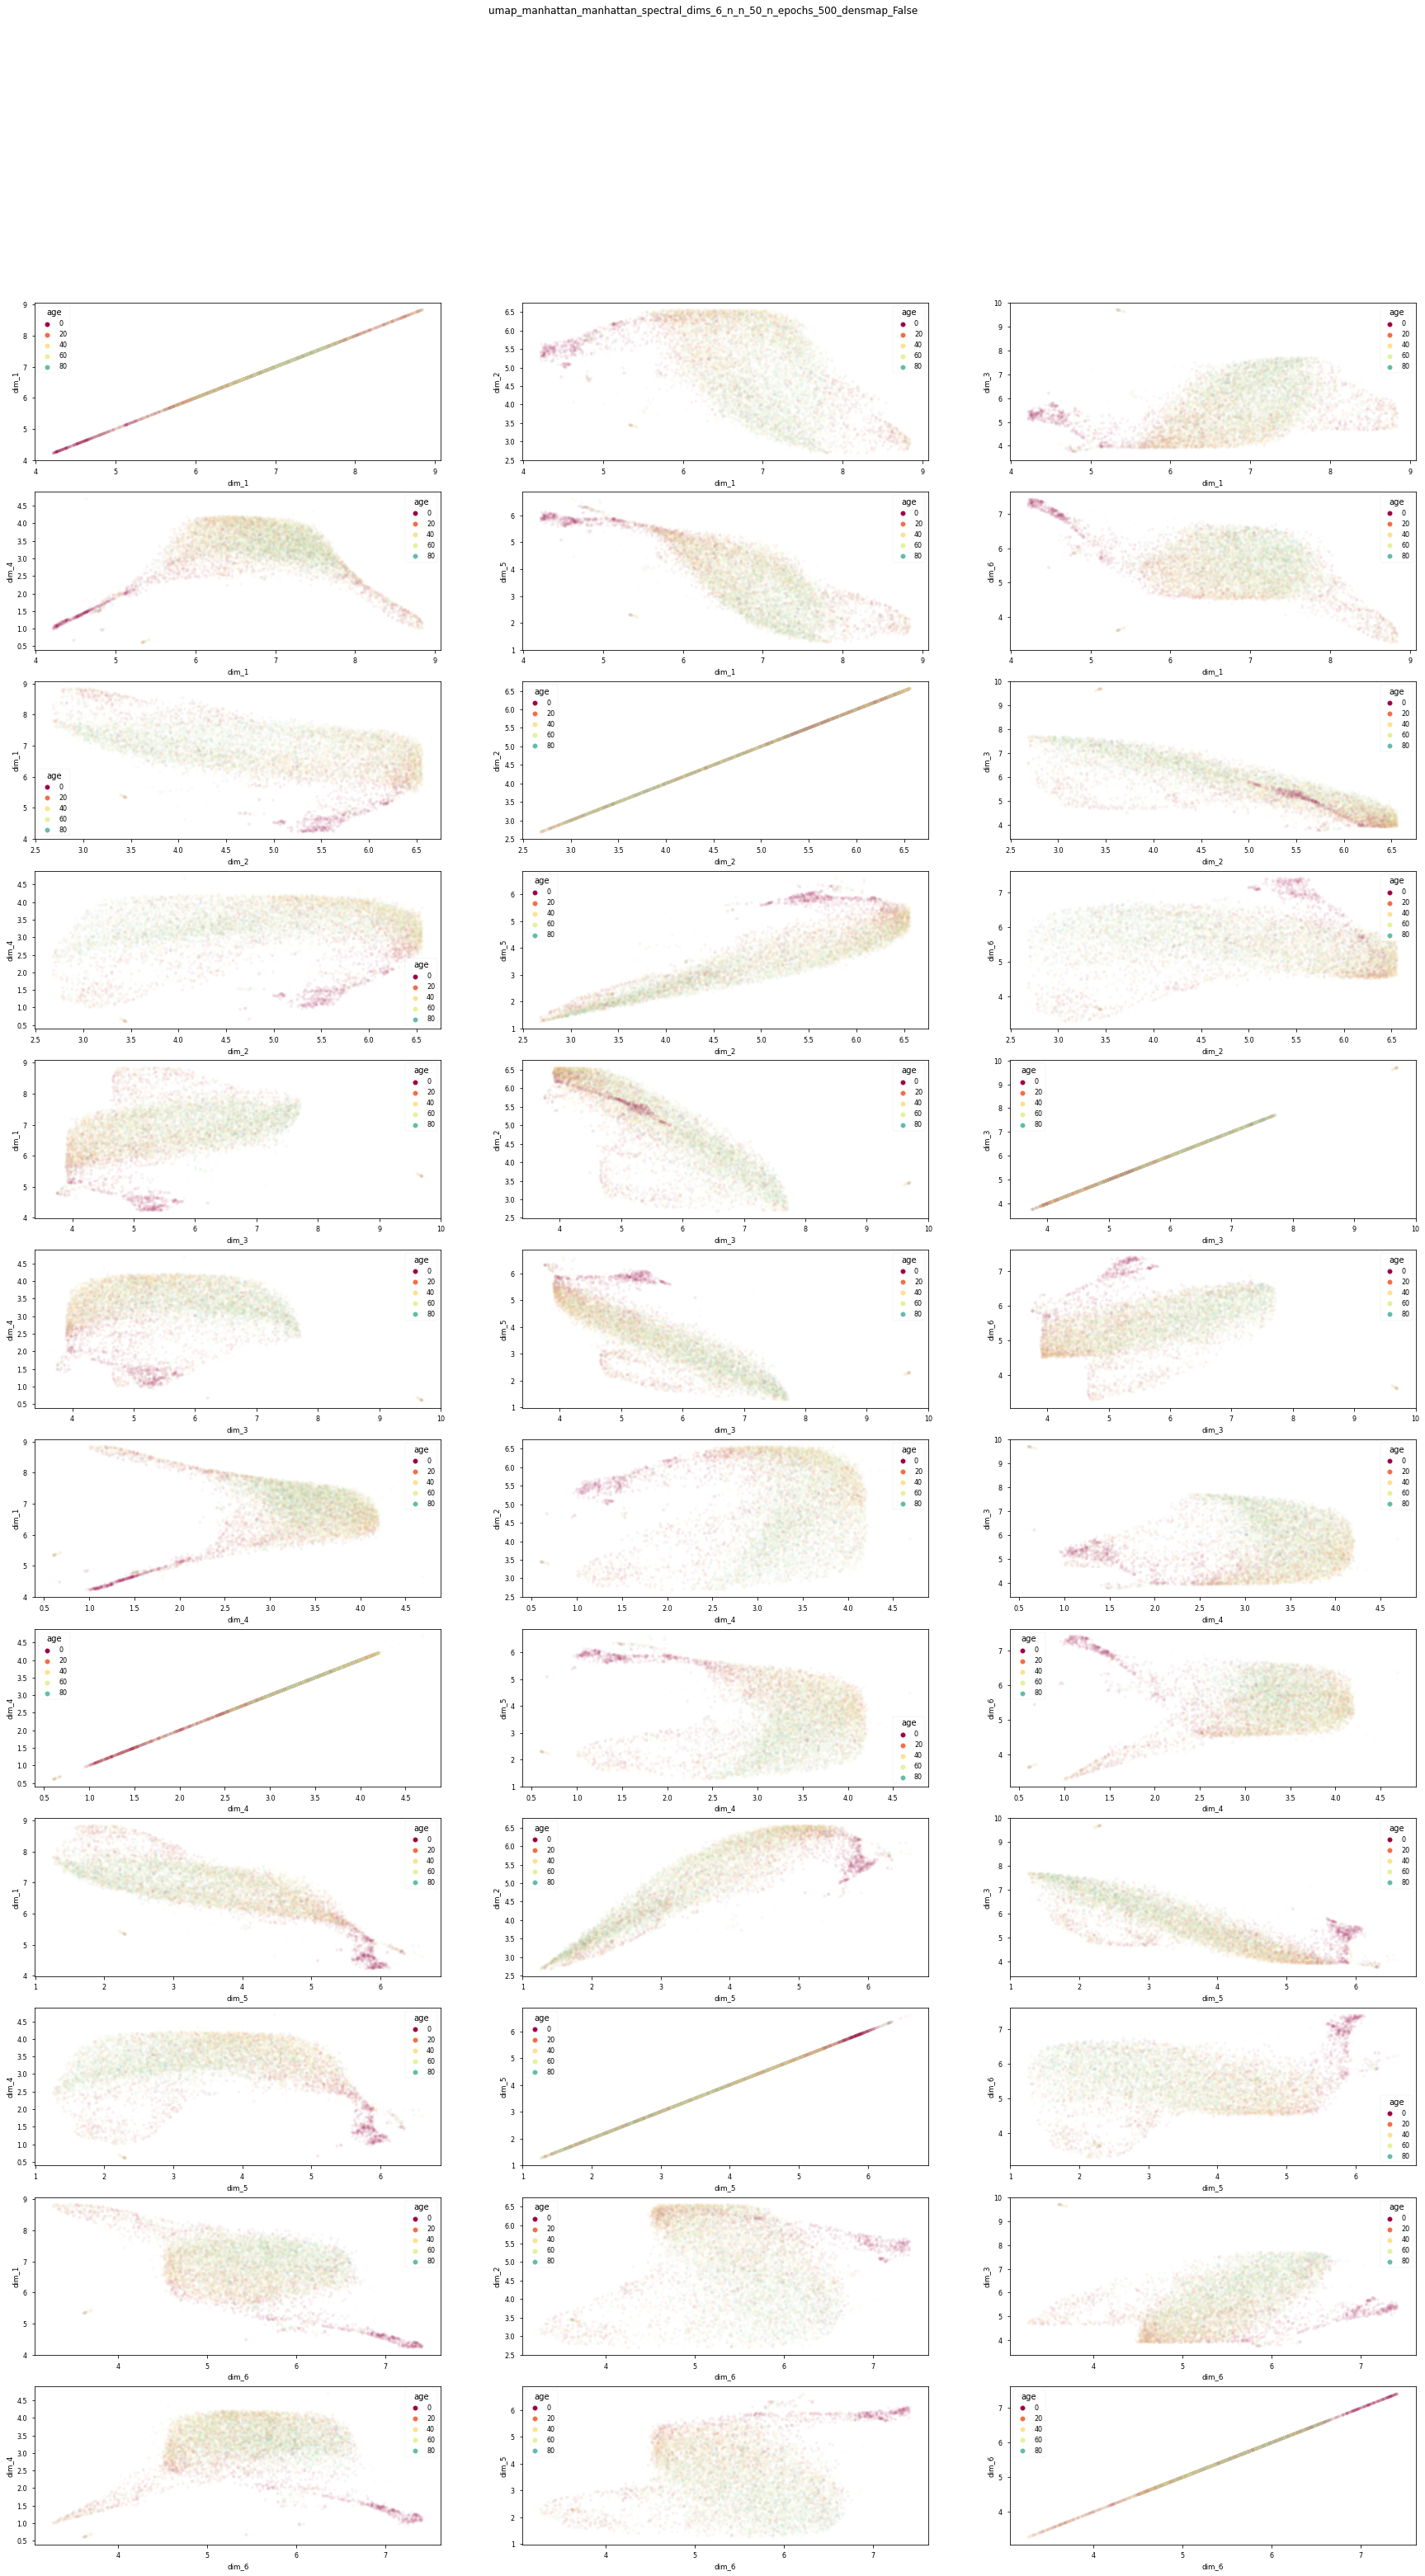

In [8]:
if plot_embedding:
    plt.style.use("seaborn-paper")

    d1q01 = embedded_data.dim_1.quantile(0.01)
    d1q99 = embedded_data.dim_1.quantile(0.99)
    d2q01 = embedded_data.dim_2.quantile(0.01)
    d2q99 = embedded_data.dim_2.quantile(0.99)

    conds = (embedded_data.dim_1>d1q01) & (embedded_data.dim_1<d1q99) & (embedded_data.dim_2>d2q01) & (embedded_data.dim_2<d2q99)

    plot_df = embedded_data.loc[conds].sample(min([10000, sum(conds)]))

    fig, ax = plt.subplots(12,3,figsize = (30,50))
    i,j = 0,0

    #sns.color_palette("vlag", as_cmap=True) # icefire, Spectral
    for colx in plot_df[[c for c in embedded_data if 'dim' in c]]:
        for coly in plot_df[[c for c in embedded_data if 'dim' in c]]:
            sns.scatterplot(data=plot_df, x=colx, y=coly,  hue='age',
                            s = 15, alpha = 0.05, ax=ax[i,j], palette="Spectral")
            i = i+1 if j == 2 else i
            j = j+1 if j < 2 else 0

    fig.suptitle(model_str)
    plt.savefig("L:\laupodteam\AIOS\Bram\data\CellDyn\\artifacts\\"+model_str+".png", dpi=300)       


In [9]:
del celldyn_full, embedded_data
gc.collect()

817

In [10]:
import dill as pickle

In [11]:
toBePersisted = dict({
    'model': le_pipe,
    'meas_cols': meas_columns,
    'metadata': {
        'name': 'Celldyn embedder',
        'embedder': 'UMAP',
        'author': 'Bram van Es, Huibert-Jan Joosse, Chontira Chumsaeng',
        'date': '2022-12-13'
    }
})

In [12]:
pickle.dump(toBePersisted, open('L:\laupodteam\AIOS\Bram\data\CellDyn\\artifacts\Embedder_'+model_str+'_.pickle', 'wb'))

Thu Dec 15 01:35:55 2022 Worst tree score: 0.99995184
Thu Dec 15 01:35:55 2022 Mean tree score: 0.99996288
Thu Dec 15 01:35:55 2022 Best tree score: 0.99997220
Thu Dec 15 01:36:49 2022 Forward diversification reduced edges from 154689600 to 38014535
Thu Dec 15 01:36:58 2022 Reverse diversification reduced edges from 38014535 to 38014526
Thu Dec 15 01:37:04 2022 Degree pruning reduced edges from 53764948 to 53732232
Thu Dec 15 01:37:04 2022 Resorting data and graph based on tree order
Thu Dec 15 01:37:14 2022 Compressing index by removing unneeded attributes
Thu Dec 15 01:37:14 2022 Building and compiling search function


In [13]:
#embedder_test = pickle.load(open('L:\laupodteam\AIOS\Bram\data\CellDyn\\artifacts\Embedder_umap_euclidean_euclidean_spectral_dims_6_n_n_50_n_epochs_400_.pickle',
#                         'rb'))

In [14]:
#embedder_test['metadata']
#embedder_test['model'].transform(celldyn_full.sample(50)[meas_columns])